# DV_Final_Project_Part2

Group Name: SSSL
Group Member: Jiaxin Song, Chaohan Shang, Yun Sun, Weihao Li.

In [1]:
%matplotlib inline

In [2]:
import re
import pandas as pd
import collections
import numpy as np
import ipywidgets
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel("DV_Dataset.xlsx")

In [4]:
data.head(5)

,Incident,Date reported,Time reported,Date occurred,Time occurred,General Location,Crime Description,Disposition
0,II1700001,2017-01-01,2:15,2017-01-01 00:00:00,2:14,GREEN E / FIRST ST,DRIVING UNDER THE INFL-ALCOHOL,ARREST
1,II1700001,2017-01-01,2:15,2017-01-01 00:00:00,2:14,GREEN E / FIRST ST,CANNABIS POSS 10 GM OR LESS -ORD,PENDING
2,II1700001,2017-01-01,2:15,2017-01-01 00:00:00,2:14,GREEN E / FIRST ST,BREATH ALCOHOL OVER LIMIT,ARREST
3,IF1700001,2017-01-01,0:43,2017-01-01 00:00:00,0:43,51 E GREGORY,FIGHT,ADMIN CLOSED
4,IF1700002,2017-01-01,1:19,2017-01-01 00:00:00,1:19,SHERMAN RESIDENCE HALL,LIQUOR - UNDERAGE,ADMIN CLOSED


In [5]:
collections.Counter(data["Disposition"])

Counter({'ADMIN CLOSED': 958,
         'ADMIN. CLOSE': 442,
         'ARREST': 545,
         'CLEARED EXCEPT. JUVENILE NO CU': 2,
         'CLEARED EXCEPT. PROS. FAIL TO': 8,
         'CLEARED EXCEPT. REFUSAL TO COO': 4,
         'PENDING': 219,
         'REFERRED TO OTHER JURISDICTION': 5,
         'REPORTED TO OTHER AGENCY': 1972,
         'STUDENT DISC REFERRAL': 222,
         'STUDENT DISCIPLINE': 137,
         'STUDENT DISCIPLINE REFERRAL': 59,
         'UNFOUNDED': 32,
         'WARNING (TRAFFIC)': 1,
         'unk': 1})

In [6]:
data["Disposition"]=data['Disposition'].replace(["ADMIN. CLOSE", "ADMIN CLOSED"], "ADMIN.CLOSED")
data["Disposition"]=data['Disposition'].replace(["STUDENT DISCIPLINE","STUDENT DISC REFERRAL"], "STUDENT DISCIPLINE REFERRAL")
collections.Counter(data["Disposition"])

Counter({'ADMIN.CLOSED': 1400,
         'ARREST': 545,
         'CLEARED EXCEPT. JUVENILE NO CU': 2,
         'CLEARED EXCEPT. PROS. FAIL TO': 8,
         'CLEARED EXCEPT. REFUSAL TO COO': 4,
         'PENDING': 219,
         'REFERRED TO OTHER JURISDICTION': 5,
         'REPORTED TO OTHER AGENCY': 1972,
         'STUDENT DISCIPLINE REFERRAL': 418,
         'UNFOUNDED': 32,
         'WARNING (TRAFFIC)': 1,
         'unk': 1})

# Classify the location into outdoor and indoor location

We use the regex to filter the 'General Location' column and divide it into two categories: Indoor & Outdoor.
In this procedure, we determine if the column contains the following characters: 'ST','DR','AV','AVE','E','N','W','S'.
For those who meet the requirements, we replace the location with 'Outside' and vice versa.

In [7]:
def location_sort(location):
    status = []
    crime = data["Crime Description"]
    st = r' ST| DR| AV| AVE| E | N | W | S |'
    Outside = 0
    Indoor = 0
    for i in range(len(location)):
        if len(set(re.findall(st,location[i])))==1:
            status.append("Outside")
            Outside +=1
        else:
            Indoor +=1
            status.append("Indoor")
    status = pd.DataFrame(status)
    result = pd.concat([location, crime, status], axis=1)
    result.columns = ['Location','Crime Description','Status']
    return result

In [8]:
# We add one column to show the status of each incident.
In_N_Out = location_sort(data["General Location"])

In [9]:
# Divide the entire dataset into two parts: indoor data and outdoor data.
in_data = []
ot_data = []
for i in range(len(In_N_Out)):
    if In_N_Out['Status'][i] == 'Indoor':
        in_data.append(In_N_Out['Crime Description'][i])
    else:
        ot_data.append(In_N_Out['Crime Description'][i])
in_data = pd.DataFrame({'Crime Description':in_data})
ot_data = pd.DataFrame({'Crime Description':ot_data})

Check the indoor and outdoor location's proportion with bar chart and pie chart.

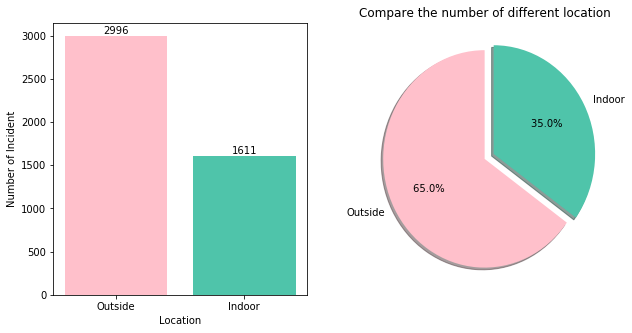

In [10]:
inou = location_sort(data["General Location"])
outnum = 0
innum = 0
for i in range(len(inou['Status'])):
    if inou['Status'][i] == 'Outside':
        outnum += 1
    else:
        innum += 1
name_list = ['Outside','Indoor']  
num_list = [outnum, innum] 

fig=plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
x = range(len(num_list))
y=num_list
color_list=['pink','#4fc4aa']
ax1.bar(x, y,color=color_list,tick_label=name_list)  
ax1.set_xlabel('Location') 
ax1.set_ylabel('Number of Incident') 
for a,b in zip(x,y):
    ax1.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
ax2 = fig.add_subplot(1,2,2)
labels = 'Outside','Indoor'
fracs = [outnum, innum]
explode = [0,0.1]
ax2.pie(x=fracs, labels=labels, explode=explode,autopct='%3.1f%% ',colors=color_list,
        shadow=True, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
plt.title('Compare the number of different location')
plt.show()

# Classify Crime Description into 9 categories.

By filtering the crime description, we normalize them into 9 types and rename them with standard tags.
We use a function named crime_type_sort to accomplish this complementation.

In [11]:
# DV for crime types
crime_1 = r'LIQUOR|ALCOHOL'
crime_2 = r'THEFT|FRAUD|STOLEN|ROBBERY|PROPERTY|BURGLARY'
crime_3 = r'DRUGS|CANNABIS|HEROIN'
crime_4 = r'BATTERY|VIOLENCE|FIGHTING'
crime_5 = r'SEX|SEXUAL|RAGE|ASSUALT'
crime_6 = r'HARASSMENT|STALKING'
crime_7 = r'SUICIDE'
crime_8 = r'WEAPON|ARMED|FOID'
crime_9 = r'I.D.'
def crime_type_sort(crime_type):  
    
    alcohol_related = 0
    property_related = 0
    drugs_related = 0
    violence_related = 0
    sexual_related = 0
    harassment_related = 0
    suicide = 0
    weapon_related = 0
    id_related = 0
    for i in range(len(crime_type)):
        crime_type[i].upper()
        if len(re.findall(crime_1,crime_type[i])) >= 1:
            alcohol_related +=1
        if len(re.findall(crime_2,crime_type[i])) >= 1:
            property_related +=1
        if len(re.findall(crime_3,crime_type[i])) >= 1:
            drugs_related +=1
        if len(re.findall(crime_4,crime_type[i])) >= 1:
            violence_related +=1
        if len(re.findall(crime_5,crime_type[i])) >= 1:
            sexual_related +=1
        if len(re.findall(crime_6,crime_type[i])) >= 1:
            harassment_related +=1
        if len(re.findall(crime_7,crime_type[i])) >= 1:
            suicide +=1
        if len(re.findall(crime_8,crime_type[i])) >= 1:
            weapon_related +=1
        if len(re.findall(crime_9,crime_type[i])) >= 1:
            id_related +=1
    return(alcohol_related,property_related,drugs_related,
          violence_related,sexual_related,harassment_related,
          suicide,weapon_related,id_related)

In [12]:
crime_type_sort(data["Crime Description"])

(652, 1154, 474, 252, 513, 127, 40, 27, 419)

We use stack chart to compare the crimes types respect to indoor and outdoor.

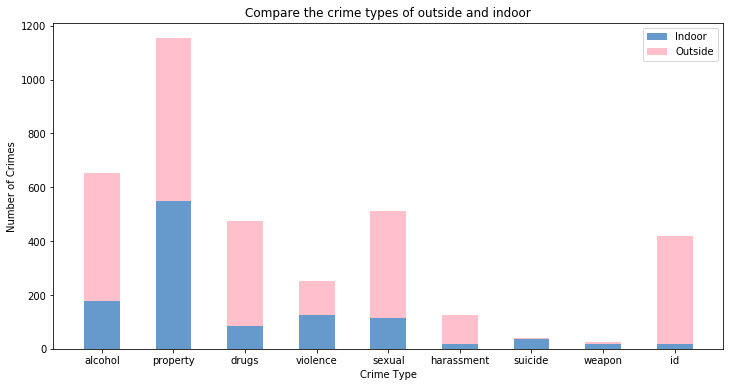

In [13]:
critypes = ['alcohol','property','drugs','violence','sexual','harassment','suicide','weapon','id']
y_in = np.array(crime_type_sort(in_data['Crime Description']))
y_out = np.array(crime_type_sort(ot_data['Crime Description']))
x = np.arange(len(critypes))
width = 0.5
fig, ax = plt.subplots(figsize=(12, 6))
rec1 = ax.bar(x, y_in, width, color='#6699CC')
rec2 = ax.bar(x, y_out, width, bottom = y_in, color='pink')
ax.set_xticks(x)
ax.set_xticklabels(critypes)
ax.legend((rec1[0], rec2[0]), ('Indoor', 'Outside'))
ax.set_xlabel('Crime Type') 
ax.set_ylabel('Number of Crimes') 
ax.set_title('Compare the crime types of outside and indoor')
plt.show()

# Occurred time VS Crime Description

In [14]:
# Extract the hour from the occurred time column 

In [15]:
time_occurred=[]
match_type = '\d+(?=:)'
for i in range(len(data["Time occurred"])):
            time_occurred.append(re.findall(match_type,data['Time occurred'][i]))
time_occurred= pd.DataFrame(time_occurred)    
time_crime = pd.concat([time_occurred,data['Crime Description'],data['General Location']], axis=1)
time_crime.columns=["Hour",'Crime Description','General Location']

We will improve the following cells in part3.

In [16]:
def drop_index(data):
    index=[]
    for i in range(len(data)):
        if data[i]==None:
            index.append(i)         
    print(index)

In [17]:
index = drop_index(time_crime['Hour'])

[23, 43, 46, 54, 73, 92, 163, 171, 178, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 240, 241, 299, 309, 310, 314, 315, 336, 344, 353, 354, 355, 356, 422, 607, 608, 609, 639, 650, 686, 687, 688, 691, 714, 715, 755, 885, 892, 919, 959, 960, 1124, 1151, 1172, 1173, 1174, 1176, 1188, 1199, 1200, 1239, 1240, 1284, 1290, 1291, 1305, 1380, 1412, 1418, 1495, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1570, 1650, 1651, 1653, 1654, 1693, 1694, 1785, 1899, 1908, 1951, 2195, 2211, 2212, 2353, 2418, 2419, 2420, 2487, 2500, 2535, 2575, 2581, 2583, 2617, 2618, 2648, 2689, 2700, 2723, 2724, 2725, 2759, 2835, 2849, 2850, 2868, 2933, 2992, 3015, 3021, 3062, 3100, 3128, 3143, 3144, 3154, 3155, 3164, 3178, 3184, 3189, 3239, 3240, 3353, 3370, 3460, 3474, 3475, 3511, 3594, 3595, 3596, 3619, 3626, 3646, 3672, 3690, 3691, 3700, 3701, 3702, 3718, 3728, 3741, 3750, 3751, 3752, 3753, 3840

In [18]:
time_crime = time_crime.drop([23, 43, 46, 54, 73, 92, 163, 171, 178, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 240, 241, 299, 309, 310, 314, 315, 336, 344, 353, 354, 355, 356, 422, 607, 608, 609, 639, 650, 686, 687, 688, 691, 714, 715, 755, 885, 892, 919, 959, 960, 1124, 1151, 1172, 1173, 1174, 1176, 1188, 1199, 1200, 1239, 1240, 1284, 1290, 1291, 1305, 1380, 1412, 1418, 1495, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1570, 1650, 1651, 1653, 1654, 1693, 1694, 1785, 1899, 1908, 1951, 2195, 2211, 2212, 2353, 2418, 2419, 2420, 2487, 2500, 2535, 2575, 2581, 2583, 2617, 2618, 2648, 2689, 2700, 2723, 2724, 2725, 2759, 2835, 2849, 2850, 2868, 2933, 2992, 3015, 3021, 3062, 3100, 3128, 3143, 3144, 3154, 3155, 3164, 3178, 3184, 3189, 3239, 3240, 3353, 3370, 3460, 3474, 3475, 3511, 3594, 3595, 3596, 3619, 3626, 3646, 3672, 3690, 3691, 3700, 3701, 3702, 3718, 3728, 3741, 3750, 3751, 3752, 3753, 3840, 4075, 4076, 4084, 4108, 4110, 4119, 4138, 4139, 4148, 4149, 4152, 4200, 4201, 4214, 4227, 4244, 4253, 4254, 4259, 4260, 4306, 4307, 4308, 4343, 4426, 4438, 4439, 4445, 4446, 4447, 4466, 4479, 4480, 4512, 4575, 4576, 4604]).reset_index(drop=True)

In [19]:
# Divide the time into three periods.
# period1: 21:00 - 3:00
# period2: 3:00 - 12:00
# period3: 12:00 - 21:00

In [20]:
period1=[]
period2 =[]
period3 =[]
index1 = []
index2 = []
index3 = []
for i in range (len(time_crime['Hour'])):
    if int(time_crime['Hour'][i]) > 21 or int(time_crime['Hour'][i]) <= 3:
                                    period1.append(time_crime['Hour'][i])
                                    index1.append(i)
    if int(time_crime['Hour'][i]) > 3 and int(time_crime['Hour'][i]) <= 12:
                                    period2.append(time_crime['Hour'][i])
                                    index2.append(i)
    if int(time_crime['Hour'][i]) > 12 and int(time_crime['Hour'][i]) <= 21:
                                    period3.append(time_crime['Hour'][i])
                                    index3.append(i)
period1 = pd.DataFrame(period1) 
period2 = pd.DataFrame(period2) 
period3 = pd.DataFrame(period3) 

In [21]:
# Classify the Crime Description repect to the three time periods.

In [22]:
crime1 = []
for i in range(len(index1)):
    crime1.append(time_crime["Crime Description"][i])
crime2 = []
for i in range(len(index2)):
    crime2.append(time_crime["Crime Description"][i])
crime3 = []
for i in range(len(index3)):
    crime3.append(time_crime["Crime Description"][i])
crime1 = pd.DataFrame(crime1) 
crime2 = pd.DataFrame(crime2) 
crime3 = pd.DataFrame(crime3) 

In [23]:
# Create a new dataframe which includes the time(hour) column and Crime Description.

In [24]:
result1 = pd.concat([period1,crime1], axis=1)
result1.columns=["Hour",'Crime Description']
result2 = pd.concat([period2,crime2], axis=1)
result2.columns=["Hour",'Crime Description']
result3 = pd.concat([period3,crime3], axis=1)
result3.columns=["Hour",'Crime Description']

In [25]:
crime_type_sort(result1["Crime Description"])
crime_type_sort(result2["Crime Description"])
crime_type_sort(result3["Crime Description"])

(210, 395, 166, 93, 185, 45, 1, 6, 194)

# Occurred time VS General Location

In [26]:
location1 = []
for i in range(len(index1)):
    location1.append(time_crime["General Location"][i])
location2 = []
for i in range(len(index2)):
    location2.append(time_crime["General Location"][i])
location3 = []
for i in range(len(index3)):
    location3.append(time_crime["General Location"][i])
location1 = pd.DataFrame(location1) 
location2 = pd.DataFrame(location2) 
location3 = pd.DataFrame(location3) 

In [27]:
time_location1= pd.concat([period1,location1], axis=1)
time_location1.columns=["Hour",'General Location']
time_location2 = pd.concat([period2,location2], axis=1)
time_location2.columns=["Hour",'General Location']
time_location3 = pd.concat([period3,location3], axis=1)
time_location3.columns=["Hour",'General Location']

In [28]:
# Analyze the incidents which are reported in one day.

In [29]:
time_series = pd.DataFrame(data['Date reported'].value_counts().reset_index())
time_series.columns = ['date', 'count']
new_ts = time_series.sort_values(by = ['date'])

In [30]:
# Use plt to plot the Crime numbers per day.

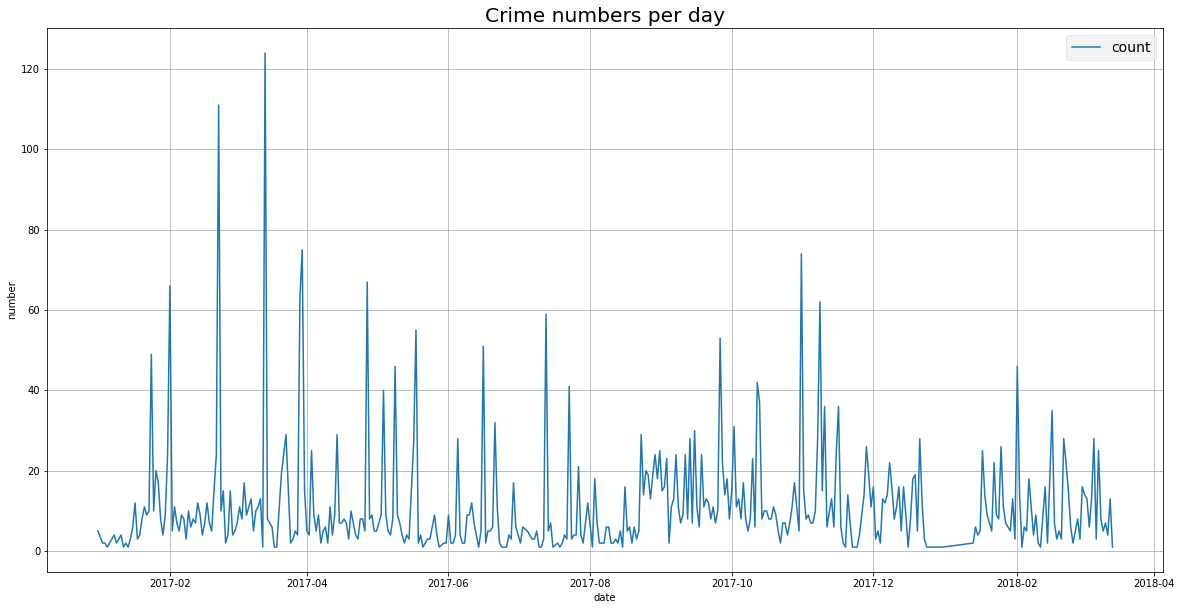

In [31]:
plt.figure(figsize=(20,10))
plt.plot(new_ts['date'],new_ts['count'])
plt.style.use('fivethirtyeight')
plt.title("Crime numbers per day")
plt.xlabel("date")
# plt.xticks(x,[i for i in data.index])
plt.ylabel("number")
# plt.plot_date(x_date,data['close'],'-',label="y")
# plt.plot_date(x_date,data['high'],'-',color='r',label="x")
plt.legend()
plt.grid(True)

In [32]:
# Analyze the likelihood of an incident reported in each hour.

In [33]:
hour_series = pd.DataFrame(time_crime['Hour'].value_counts().reset_index())
hour_series.columns = ['hour', 'count']
hour_series["hour"] = hour_series["hour"].astype(int)
hour_series["count"] = hour_series["count"].apply(lambda x: x/439200*100)
new_hs = hour_series.sort_values(by = ['hour'])

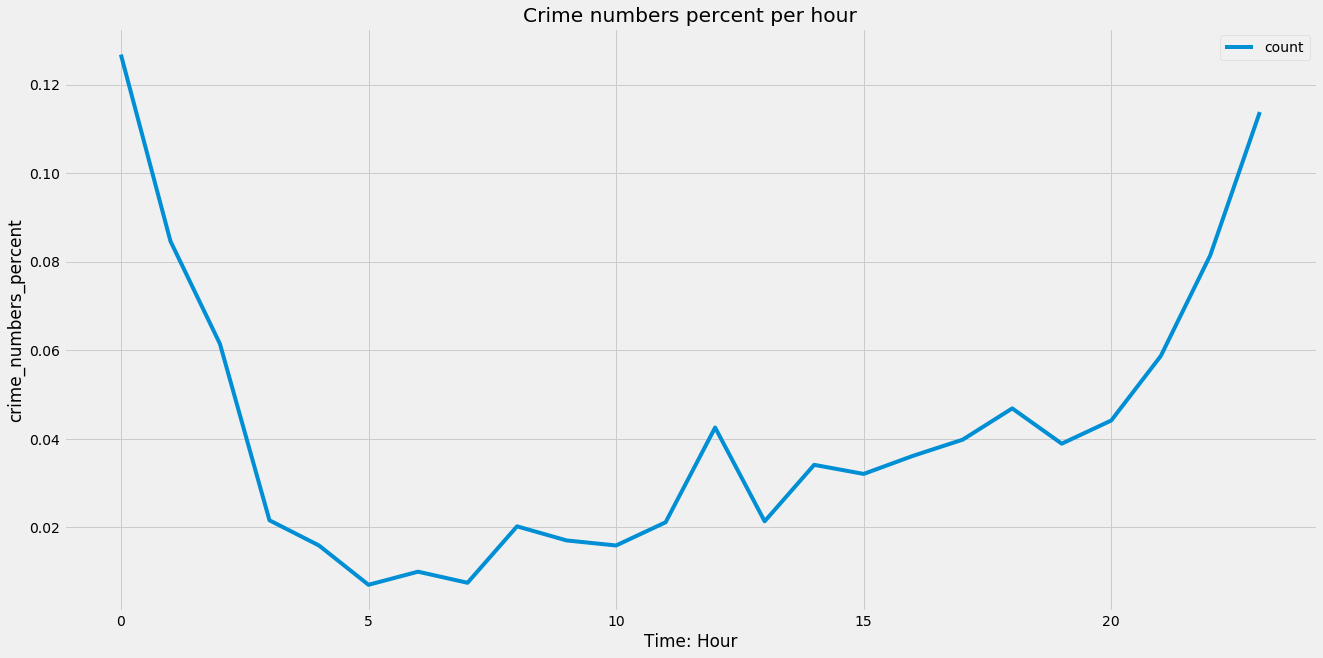

In [34]:
plt.figure(figsize=(20,10))
plt.plot(new_hs['hour'],new_hs['count'])
plt.style.use('fivethirtyeight')
plt.title("Crime numbers percent per hour")
plt.xlabel("Time: Hour")
plt.ylabel("crime_numbers_percent")
plt.legend()
plt.grid(True)

In [35]:
#common location top10 (building)
#common location: RED LION, SDRP, ILLINI UNION BOOKSTORE, JOE'S BREWERY, KAMS
#               ILLINI UNION, CLYBOURNE, ALLEN RESIDENCE HALL, OGLESBY RESIDENCE HALL, WESTON RESIDENCE HALL

In [36]:
# Use most_common function to see the top10 building location.

In [37]:
Location = collections.Counter(data["General Location"])
Location.most_common()

[('RED LION', 281),
 ('UNKNOWN LOCATION', 87),
 ('SDRP', 81),
 ('ILLINI UNION BOOKSTORE', 70),
 ("JOE'S BREWERY", 62),
 ('KAMS', 59),
 ('ILLINI UNION', 55),
 ('PRIVATE APARTMENT', 54),
 ('CLYBOURNE', 53),
 ('ALLEN RESIDENCE HALL', 49),
 ('blk of E JOHN ST', 42),
 ('OGLESBY RESIDENCE HALL', 41),
 ('ON CAMPUS', 40),
 ('WESTON RESIDENCE HALL', 38),
 ('JOES BREWERY', 38),
 ('COUNTY MARKET', 38),
 ('SCOTT RESIDENCE HALL', 37),
 ('TOWNSEND RESIDENCE HALL', 37),
 ('HOPKINS RESIDENCE HALL', 37),
 ('WASSAJA RESIDENCE HALL', 37),
 ('ARC', 35),
 ('TRELEASE RESIDENCE HALL', 35),
 ('BROTHERS BAR', 35),
 ('ILLINOIS TERMINAL', 31),
 ('200 blk of E GREEN ST', 31),
 ('300 blk of E GREEN ST', 30),
 ('CIRCLE K', 25),
 ('SHERMAN RESIDENCE HALL', 22),
 ('WESTON RES HALL', 21),
 ('ALLEN RES HALL', 21),
 ('CARR RESIDENCE HALL', 21),
 ('SNYDER RESIDENCE HALL', 21),
 ('300 blk of E JOHN ST', 21),
 ('RESIDENCE HALL', 21),
 ('VAN DOREN RESIDENCE HALL', 20),
 ('400 blk of E GREEN ST', 19),
 ('OGLESBY RES HALL', 1

In [38]:
# Interaction for time period vs general location.

In [39]:
@ipywidgets.interact(time_location = ['period1: 21:00-3:00','period2: 3:00-12:00','period3: 12:00-21:00'],)
def print_bandname(time_location):
    plt.xticks([])
    plt.xlabel("General Location")
    plt.ylabel("Count of locations")
    if time_location=='period1: 21:00-3:00':
        plt.plot(time_location1.groupby("General Location").count())
    if time_location=='period2: 3:00-12:00':
        plt.plot(time_location2.groupby("General Location").count())
    if time_location=='period3: 12:00-21:00':
        plt.plot(time_location3.groupby("General Location").count())

interactive(children=(Dropdown(description='time_location', options=('period1: 21:00-3:00', 'period2: 3:00-12:00', 'period3: 12:00-21:00'), value='period1: 21:00-3:00'), Output()), _dom_classes=('widget-interact',))

# Top 10 dangerous buildings respect to various time periods.

In [40]:
# Demostrate the number of incidents in each time period regarding Top10 most common location.

In [41]:
t_l_index1=[]
t_l_index2=[]
t_l_index3=[]
common_location = ['Red Lion','SDRP','ILLINI UNION BOOKSTORE',"JOE'S BREWERY",'KAMS','ILLINI UNION','CLYBOURNE','ALLEN RESIDENCE HALL',
                  'OGLESBY RESIDENCE HALL','WESTON RESIDENCE HALL']

for location in range(len(common_location)):
    for i in range(len(time_location1)):
        if time_location1["General Location"][i] == common_location[location]:
            t_l_index1.append(i)
    for i in range(len(time_location2)):
        if time_location2["General Location"][i] == common_location[location]:
            t_l_index2.append(i)
    for i in range(len(time_location3)):
        if time_location3["General Location"][i] == common_location[location]:
            t_l_index3.append(i)
t_l_index1.sort()
t_l_index2.sort()
t_l_index3.sort()

In [42]:
top_time_location1=time_location1.iloc[t_l_index1]
top_time_location2=time_location2.iloc[t_l_index2]
top_time_location3=time_location3.iloc[t_l_index3]

In [43]:
top_time_location1.groupby("General Location").count()

,Hour
General Location,
ALLEN RESIDENCE HALL,7
CLYBOURNE,33
ILLINI UNION,28
ILLINI UNION BOOKSTORE,29
JOE'S BREWERY,30
KAMS,27
OGLESBY RESIDENCE HALL,9
SDRP,41
WESTON RESIDENCE HALL,16


In [44]:
# Use ipwidgets to implement the intercation for the number of incidents in each most common buildings vs three time periods.

In [45]:
@ipywidgets.interact(time_period = ['period1: 21:00-3:00','period2: 3:00-12:00','period3: 12:00-21:00'])
def print_bandname(time_period):
    if time_period=='period1: 21:00-3:00':
        sns.countplot(y="General Location", data=top_time_location1)
    if time_period=='period2: 3:00-12:00':
        sns.countplot(y="General Location", data=top_time_location2)
    if time_period=='period3: 12:00-21:00':
        sns.countplot(y="General Location", data=top_time_location3)

interactive(children=(Dropdown(description='time_period', options=('period1: 21:00-3:00', 'period2: 3:00-12:00', 'period3: 12:00-21:00'), value='period1: 21:00-3:00'), Output()), _dom_classes=('widget-interact',))

In [46]:
# The relation between numbers of crimes and different times. 

In [47]:
period1_count=pd.DataFrame(result1["Hour"].value_counts().reset_index())
period1_count.columns = ['Hour', 'Count of Crime']
period2_count=pd.DataFrame(result2["Hour"].value_counts().reset_index())
period2_count.columns = ['Hour', 'Count of Crime']
period3_count=pd.DataFrame(result3["Hour"].value_counts().reset_index())
period3_count.columns = ['Hour', 'Count of Crime']

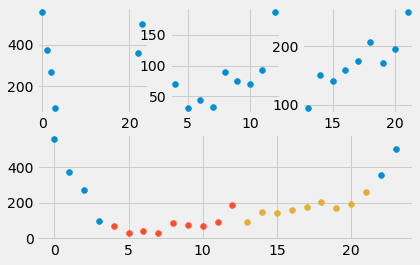

In [48]:
plt.figure(12)
plt.ylabel('Count of Crime')
plt.ylabel('Hour')
plt.subplot(231)
plt.scatter(period1_count["Hour"].astype(int),period1_count["Count of Crime"]) 
plt.subplot(232)
plt.scatter(period2_count["Hour"].astype(int),period2_count["Count of Crime"]) 
plt.subplot(233)
plt.scatter(period3_count["Hour"].astype(int),period3_count["Count of Crime"]) 
plt.subplot(212)
plt.scatter(period1_count["Hour"].astype(int),period1_count["Count of Crime"]) 
plt.scatter(period2_count["Hour"].astype(int),period2_count["Count of Crime"])
plt.scatter(period3_count["Hour"].astype(int),period3_count["Count of Crime"]) 

# Crime types in various time periods

In [49]:
# This is a visualization of the number of incidents regarding the crime categories.

In [50]:
Morning = crime_type_sort(result1["Crime Description"])
Afternoon = crime_type_sort(result2["Crime Description"])
Night = crime_type_sort(result3["Crime Description"])

In [51]:
crime_cpy = time_crime
for i in range(len(crime_cpy['Crime Description'])):
    if len(re.findall(crime_1,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'alcohol_related'
    if len(re.findall(crime_2,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'property_related'
    if len(re.findall(crime_3,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'drugs_related'
    if len(re.findall(crime_4,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'violence_related'
    if len(re.findall(crime_5,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'sexual_related'
    if len(re.findall(crime_6,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'harassment_related'
    if len(re.findall(crime_7,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'suicide'
    if len(re.findall(crime_8,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'weapon_related'
    if len(re.findall(crime_9,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'id_related'

In [52]:
crime_type = ['alcohol_related','property_related','drugs_related',
              'violence_related','sexual_related','harassment_related',
              'suicide','weapon_related','id_related']
colors = ['#e6194b','#3cb44b','#ffe119','#0082c8','#f58231',
         '#911eb4','#46f0f0','#f032e6','#ffd8b1']
explode = (0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02)

In [53]:
@ipywidgets.interact(Time = ['Morning 3:00 - 12:00', 
                             'Afternoon 12:00 - 21:00', 
                             'Night 21:00 - 3:00'])
def print_bar_plot(Time):
    if Time == 'Morning 3:00 - 12:00':
        data = Morning
    if Time == 'Afternoon 12:00 - 21:00':
        data = Afternoon
    if Time == 'Night 21:00 - 3:00':
        data = Night
    fig, ax = plt.subplots()
    y_pos = np.arange(len(crime_type))
    ax.barh(y_pos, data, 
            align='center',
            color='#aac5ff', 
            ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(crime_type)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of Incident')
    plt.show()

interactive(children=(Dropdown(description='Time', options=('Morning 3:00 - 12:00', 'Afternoon 12:00 - 21:00', 'Night 21:00 - 3:00'), value='Morning 3:00 - 12:00'), Output()), _dom_classes=('widget-interact',))

In [54]:
# This is a visualization of the components of the crime types in different time periods.

In [55]:
@ipywidgets.interact(Time = ['Morning 3:00 - 12:00', 
                             'Afternoon 12:00 - 21:00', 
                             'Night 21:00 - 3:00'])
def print_pie_chart(Time):
    if Time == 'Morning 3:00 - 12:00':
        data = Morning
    if Time == 'Afternoon 12:00 - 21:00':
        data = Afternoon
    if Time == 'Night 21:00 - 3:00':
        data = Night
        
    colors = ['#ff9999','#66b3ff','#99ff99',
              '#f1c5f1','#ffbb99','#33bb33',
              '#aac5ff','#11aa99','#6633bb']
    fig1, ax1 = plt.subplots()
    ax1.pie(data, 
            colors = colors, 
            explode=explode,
            labels=crime_type, 
            autopct='%1.1f%%', startangle=90)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Time', options=('Morning 3:00 - 12:00', 'Afternoon 12:00 - 21:00', 'Night 21:00 - 3:00'), value='Morning 3:00 - 12:00'), Output()), _dom_classes=('widget-interact',))